# Business Understanding

This dataset is from a Portuguese financial institution and aims to determine whether potential customers will enter into a term deposit with the bank based on a number of factors. This data was collected through phone calls with potential customers, and is highly valuable information for this institution as well as any other financial institutions across the globe. For example, banks can use this information to identify high-potential customers and allocate their marketing resources more effectively. We believe that an AUC of 0.7 or higher would be valuable information for banks around the world, especially because we are dealing with a somewhat sizable dataset. An AUC of 0.8 or higher would certainly be of use to other institutions. The higher the AUC, the more confident that can be in allocating resources towards certain groups of people.

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as mn

In [102]:
bank_data = pd.read_csv("bank-full.csv", delimiter=";")

# Data Description

In [41]:
bank_data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

**age: int64**
- The age of the potential customer. Ranges from 18 to 95 years old.

**job: object**
- The potential customer's job category. There are 12 total categories of jobs, one of which is "unknown", which we will treat as missing.

**marital: object**
- The potential customer's marital status. This can be "married", "single", or "divorced".

**education: object**
- The education level of the potential customer. The categories for this variable are "secondary", "tertiary", "primary", or "unknown" (which will be treated as missing).

**default: object**
- A binary variable that describes whether or not the potential customer has credit in default. The two factor levels for this variable are "yes" and "no".

In [49]:
bank_data.default.value_counts()

default
no     44396
yes      815
Name: count, dtype: int64

# Data Quality

### Duplicate Data

In [59]:
sum(bank_data.duplicated())

0

The above code shows that there are no duplicate rows in our data. The duplicated() function returns a boolean series, and the sum function adds up all the boolean values as True=1 and False=0. Because the sum of the series is 0, we know that there are no duplicates. As a result, no rows need to be removed due to duplication.

### Missing Data

In [68]:
bank_data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

The above code shows that are data has no null values. However, this does not mean that we have no missing data, as missing data can be "unknown" in categorical variables.

In [83]:
cat_vars = ["job", "marital", "education",
            "default", "housing", "loan",
            "contact", "day", "month",
           "poutcome"]

for x in cat_vars:
    print(bank_data[x].value_counts())

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64
default
no     44396
yes      815
Name: count, dtype: int64
housing
yes    25130
no     20081
Name: count, dtype: int64
loan
no     37967
yes     7244
Name: count, dtype: int64
contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64
day
20    2752
18    2308
21    2026
17    1939
6     1932
5     1910
14    1848
8     1842
28    1830
7     1817
19    1757
29    1745
15    1703
12    1603
13    1585
30    1566
9     1561
11    1479
4     1445
16    1415
2     1293
27 

From the above output, we can see that "job", "education", "contact", and "poutcome" all have "unknown" values. These will either need to be imputed or removed from the data.

In [105]:
# Convert all "unknown" values to null
df = bank_data.replace("unknown", np.nan)

In [107]:
df.isnull().sum()

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

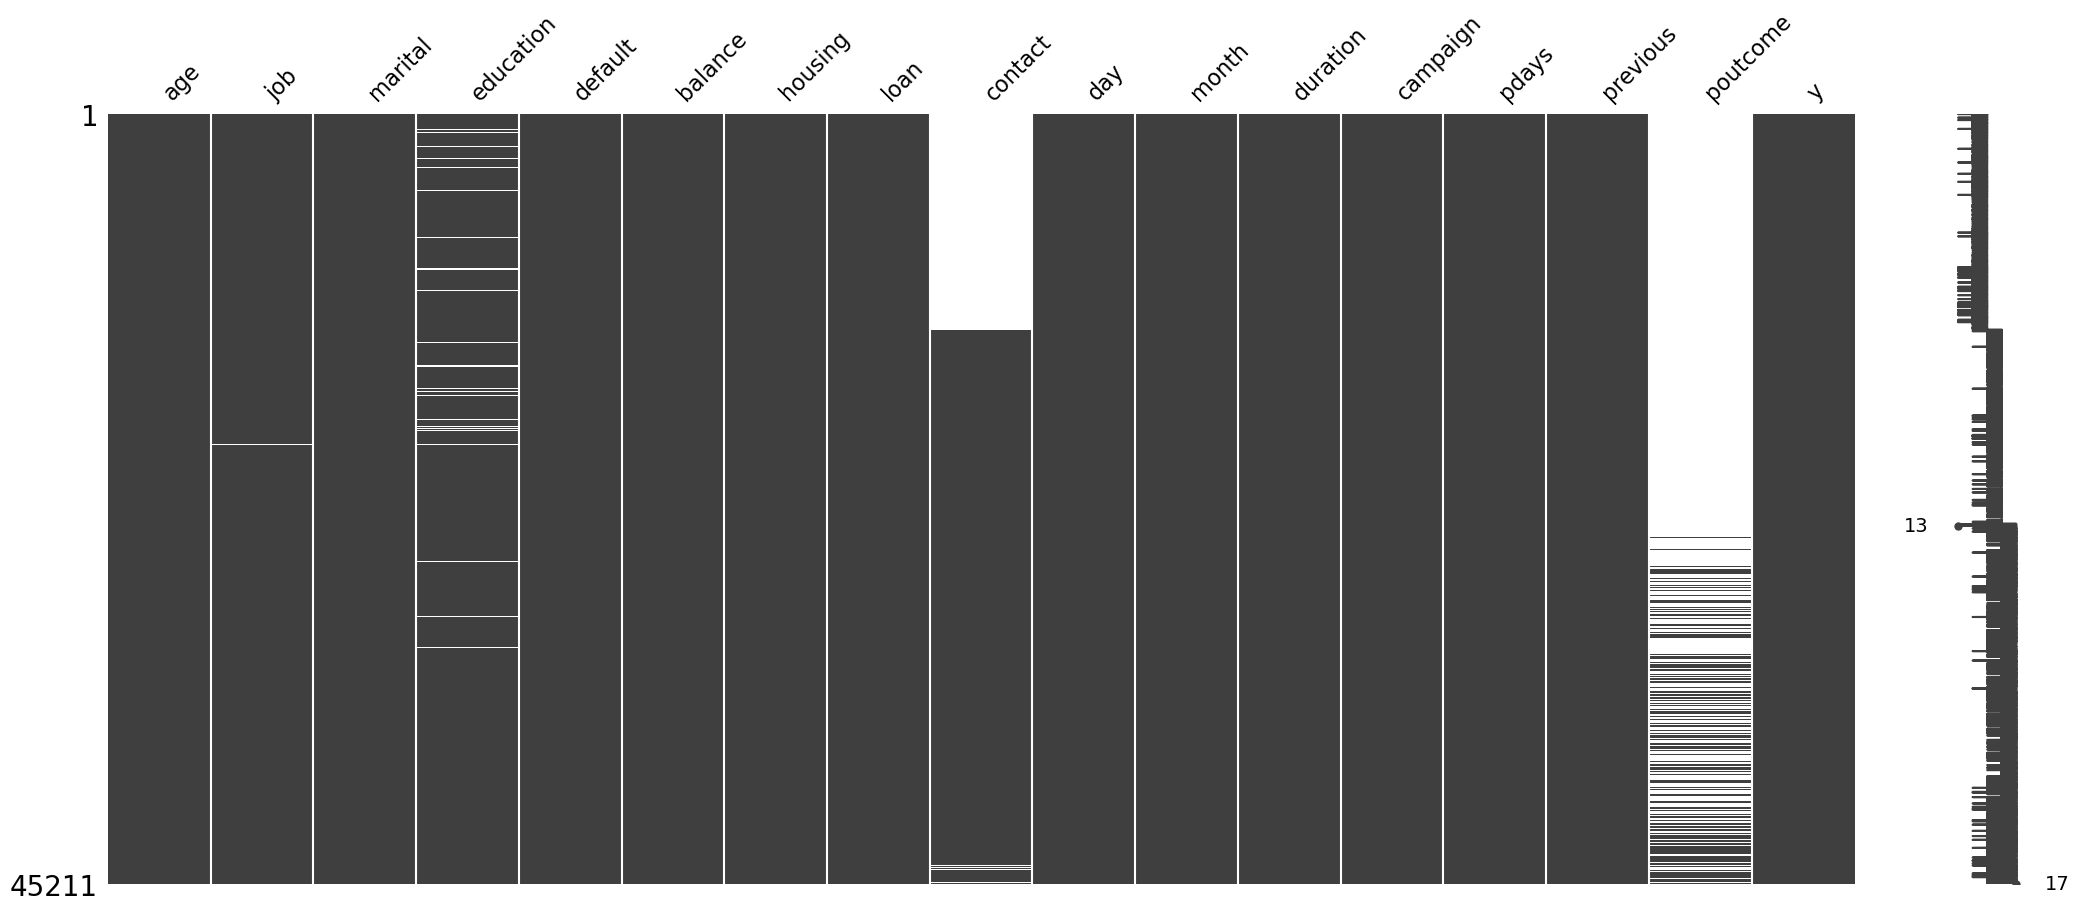

<Figure size 640x480 with 0 Axes>

In [111]:
# Plot missing values
mn.matrix(df) 
plt.figure()
plt.show()

### Job

Given the fact that all missing data are labeled "unkown", it does not seem that the values are missing due to a mistake such as a recording error. It may be the case that these customers did not want to specify their occupation. It is also important to note that there is a factor level for unemployed customers, so we know that "unknown" does not mean "unemployed". Because very few data points are missing for this column, we will use KNN imputation to impute all missing values for job.